# Sujet 5 - Analyse des dialogues dans l'Avare de Molière

## Récupérer les données

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import re

L’Observatoire de la vie littéraire (OBVIL) promeut une approche de l'analyse des textes littéraires fondée sur le numérique. Dans le cadre du Projet Molière, des pièces de cet auteur ont été numérisées et sont accessibles librement dans différents formats utilisables par un programme informatique. Nous allons utiliser ici les textes sous format markdown accessibles [ici](http://dramacode.github.io/markdown/moliere_avare.txt).

In [2]:
data_url = 'http://dramacode.github.io/markdown/moliere_avare.txt'

Pour plus de reproductibilité, nous allons télécharger les données dans ce répertoire GitLab d'abord puis nous allons lire ce fichier plutôt que l'url directement.

In [3]:
data_file = "moliere_avare.txt"

import os
import urllib.request
if not os.path.exists(data_file):
    urllib.request.urlretrieve(data_url, data_file)

Nous pouvons regarder les premières lignes de ce fichier:

In [4]:
%load_ext rpy2.ipython

In [5]:
%%sh
head -n 55 moliere_avare.txt

---
identifier: moliere_avare  
creator: Molière.  
date: 1668  
title: L'Avare. Comédie  
---


L'AVARE,

COMÉDIE.

Par J.B.P. MOLIÈRE.

À PARIS, Chez JEAN RIBOU, au Palais, vis à vis la Porte de l'Église de la Sainte Chapelle, à l'Image Saint-Louis. M. DC. LXIX. *AVEC PRIVILÈGE DU ROI*



# ACTEURS.
 – Harpagon, Père de Cléante et d'Élise, et Amoureux de Mariane.
 – Cléante, Fils d'Harpagon, Amant de Mariane.
 – Élise, Fille d'Harpagon, Amante de Valère.
 – Valère, Fils d'Anselme, et Amant d'Élise.
 – Mariane, Amante de Cléante, et aimée d'Harpagon.
 – Anselme, Père de Valère et de Mariane.
 – Frosine, Femme d'Intrigue.
 – Maitre Simon, Courtier.
 – Maitre Jacques, Cuisinier et Cocher d'Harpagon.
 – La Flèche, Valet de Cléante.
 – Dame Claude, Servante d'Harpagon.
 – Brindavoine, laquais d'Harpagon.
 – La Merluche, laquais d'Harpagon.
 – Le commissaire, et son clerc.
La Scène est à Paris.



# L'Avare, *Comédie.*.


## Acte Premier.


### Scène Première.
Valère, Élise


    VALÈRE.
H

Comme nous pouvons le voir, les actes sont marqués par un double-dièse en début de ligne et les scènes sont marquées par un triple-dièse en début de ligne. Les dialogues de personnages ont l'air d'être sur 2 lignes : une première avec le nom du personnage en majuscule et une deuxième avec les répliques du personnage.

Nous allons tenter de réarranger les données sous forme de tableau, comme ceci :

| Personnage | Acte | Scene | Nombre de Mots | Nombre de Repliques |
|:-------|:------|:-------|:------------|:----------------|
| nom du personnage | acte dans lequel il apparait | scène dans laquelle il figure | le nombre de mots qu'il parle | le nombre de repliques |

Nous allons créer un fonction qui va remplacer les caractères à accent en caractère "normaux":

In [6]:
import unicodedata

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

Comme nous pouvons le voir, il y a quelques discordances entre la liste des personnages énumérés en-dessous du numéro de scène et les répliques dans le dialogue.

In [17]:
acte = 0
scene = 0
infos_scene = {}

data = []
with open(data_file) as f:
    lines = f.readlines()
nbline = 0
while nbline < len(lines):
    line = lines[nbline]
    if line.startswith("## Acte"):
        acte += 1
    elif line.startswith("### Sc"):
        if infos_scene:
            data += infos_scene.values()
        scene += 1
        nbline += 1
        line = lines[nbline]
        if line.strip():
            infos_scene = {l.strip().upper():{'acte':acte,'scene':scene,'personnage':l.strip().upper(),'nombre_de_mots':0,'nombre_de_repliques':0} for l in remove_accents(line.strip()).split(",")}
        else:
            infos_scene = {}
            print("No characters listed for scene",scene,"acte",acte)
    elif re.search(r"^    [A-ZÈÉ ]+.$",line):
        assert acte and scene
        personnage = remove_accents(re.search(r"^    ([A-ZÈÉ ]+).$",line).groups()[0])
        nbline += 1
        line = lines[nbline]
        assert line.strip() # check line is not empty
        nombre_de_mots = len(line.split()) # on va supposer que la ponctuation est négligeable dans le compte
        if personnage not in infos_scene:
            print(personnage,"is not listed under scene",scene,"acte",acte,"but is speaking")
            infos_scene[personnage] = {'acte':acte,'scene':scene,'personnage':personnage,'nombre_de_mots':0,'nombre_de_repliques':0}
        infos_scene[personnage]['nombre_de_repliques'] += 1
        infos_scene[personnage]['nombre_de_mots'] += nombre_de_mots
    nbline += 1
df = pd.DataFrame(data)
df.head()

VALERE is not listed under scene 19 acte 3 but is speaking
No characters listed for scene 26 acte 4
HARPAGON is not listed under scene 26 acte 4 but is speaking


acte  nombre_de_mots  nombre_de_repliques personnage  scene
0     1             596                    8     VALERE      1
1     1             473                    8      ELISE      1
2     1             725                   10    CLEANTE      2
3     1             150                    9      ELISE      2
4     1             396                   34   HARPAGON      3

Voyons voir s'il y a bien le bon nombre d'Actes et de Scènes:

In [8]:
%%sh
grep -c "## Acte" moliere_avare.txt
grep -c "### Scène" moliere_avare.txt

5
32


In [9]:
df.acte.value_counts().shape

(5,)

In [10]:
df.scene.value_counts().shape

(31,)

In [11]:
df.personnage.value_counts().shape

(15,)

On voit donc qu'on retrouve le même nombre d'actes et de scènes qu'avec l'analyse de texte via `grep`. On retrouve aussi les 15 personnages listées en début de document.

In [12]:
print("".join(lines[19:33]))

 – Harpagon, Père de Cléante et d'Élise, et Amoureux de Mariane.
 – Cléante, Fils d'Harpagon, Amant de Mariane.
 – Élise, Fille d'Harpagon, Amante de Valère.
 – Valère, Fils d'Anselme, et Amant d'Élise.
 – Mariane, Amante de Cléante, et aimée d'Harpagon.
 – Anselme, Père de Valère et de Mariane.
 – Frosine, Femme d'Intrigue.
 – Maitre Simon, Courtier.
 – Maitre Jacques, Cuisinier et Cocher d'Harpagon.
 – La Flèche, Valet de Cléante.
 – Dame Claude, Servante d'Harpagon.
 – Brindavoine, laquais d'Harpagon.
 – La Merluche, laquais d'Harpagon.
 – Le commissaire, et son clerc.



## Analyser les données

Classons les personnages selon la quantité de parole grâce à une analyse syntaxique du texte (scènes / répliques / mots). En particulier, quel est celui qui parle le plus ? Quel est celui qui ne parle pas du tout ?

In [179]:
pd.DataFrame(df.personnage.value_counts())

personnage
HARPAGON                22
FROSINE                 14
CLEANTE                 14
ELISE                   13
MARIANE                 11
VALERE                   8
MAITRE JACQUES           8
LA FLECHE                5
LE COMMISSAIRE           5
SON CLERC                5
BRINDAVOINE              2
LA MERLUCHE              2
DAME CLAUDE              1
ANSELME                  1
MAITRE SIMON             1

In [14]:
df[['nombre_de_mots','personnage']].groupby('personnage').sum().sort_values(by=['nombre_de_mots'])

nombre_de_mots
personnage                    
DAME CLAUDE                  0
MAITRE JACQUES               0
MAITRE SIMON                 0
SON CLERC                    0
BRINDAVOINE                 38
LA MERLUCHE                 49
LE COMMISSAIRE             258
ANSELME                    383
MARIANE                    819
ELISE                      893
LA FLECHE                 1419
FROSINE                   2033
VALERE                    2532
CLEANTE                   3046
HARPAGON                  5092

In [15]:
df[['nombre_de_repliques','personnage']].groupby('personnage').sum().sort_values(by=['nombre_de_repliques'])

nombre_de_repliques
personnage                         
DAME CLAUDE                       0
MAITRE JACQUES                    0
MAITRE SIMON                      0
SON CLERC                         0
BRINDAVOINE                       3
LA MERLUCHE                       5
ANSELME                          14
LE COMMISSAIRE                   15
MARIANE                          26
ELISE                            50
FROSINE                          59
LA FLECHE                        64
VALERE                           99
CLEANTE                         156
HARPAGON                        334

On voit dans ces analyses qu'Harpagon participe au plus grand nombre de scènes (22 sur 31). En terme de nombre de mots parlés, Harpagon est aussi celui qui parle le plus avec Dame Claude, Maitre Jacques, Maitre Simon et le clerc qui ne parlent pas du tout. C'est aussi Harpagon qui a le plus grand nombre de répliques.

Nous allons maintenant représenter la distribution des nombres de mots parlés par personne dans chaque scène sous forme de graphique. Pour cela, nous allons tout d'abord mettre en forme les données en extrayant les colonnes qui nous intéressent et en les formatant de "long" à "wide" (2D) compatible à pd.plot.

In [149]:
df_wc = df[['scene','personnage','nombre_de_mots']].groupby(['scene','personnage']).sum().reset_index()
df_wc.sort_values(by='nombre_de_mots').tail()

scene personnage  nombre_de_mots
11      5     VALERE             621
2       2    CLEANTE             725
13      6  LA FLECHE             853
8       4   HARPAGON            1044
22     10    FROSINE            1234

In [175]:
df2d_wc = df_wc.pivot('scene', 'personnage', 'nombre_de_mots').fillna(0).reset_index()  #Reshape from long to wide
df2d_wc.head()

personnage  scene  ANSELME  BRINDAVOINE  CLEANTE  DAME CLAUDE  ELISE  FROSINE  \
0               1      0.0          0.0      0.0          0.0  473.0      0.0   
1               2      0.0          0.0    725.0          0.0  150.0      0.0   
2               3      0.0          0.0      0.0          0.0    0.0      0.0   
3               4      0.0          0.0    211.0          0.0  147.0      0.0   
4               5      0.0          0.0      0.0          0.0   36.0      0.0   

personnage  HARPAGON  LA FLECHE  LA MERLUCHE  LE COMMISSAIRE  MAITRE JACQUES  \
0                0.0        0.0          0.0             0.0             0.0   
1                0.0        0.0          0.0             0.0             0.0   
2              396.0      242.0          0.0             0.0             0.0   
3             1044.0        0.0          0.0             0.0             0.0   
4              238.0        0.0          0.0             0.0             0.0   

personnage  MAITRE SIMON  MARIANE  SON CLERC  VALERE  
0                    0.0      0.0        0.0   596.0  
1                    0.0      0.0        0.0     0.0  
2                    0.0      0.0        0.0     0.0  
3                    0.0      0.0        0.0     0.0  
4                    0.0      0.0        0.0   621.0

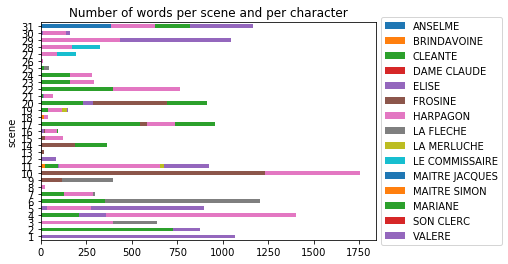

In [174]:
df2d_wc.plot(x = 'scene',
    kind = 'barh',
    stacked = True,
    title = 'Number of words per scene and per character',
    mark_right = True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

Let's now plot the interactions between characters as a network where nodes are characters and edges are plotted if these characters are together in a scene.

In [215]:
edges = {}
for scene in df.scene.unique():
    personnages = sorted(list(df[df.scene==scene].personnage))
    for p1 in range(0,len(personnages)-1):
        for p2 in range(p1+1,len(personnages)):
            if personnages[p1] not in edges:
                edges[personnages[p1]] = {}
            if personnages[p2] not in edges[personnages[p1]]:
                edges[personnages[p1]][personnages[p2]] = 0
            edges[personnages[p1]][personnages[p2]] += 1
edges_tuples = []
for p1,d in edges.items():
    for p2,count in d.items():
        edges_tuples.append([p1,p2,count])
df_edges = pd.DataFrame(edges_tuples, columns=['source','target','weight'])

In [220]:
df_edges.sort_values(by='weight').tail()

source    target  weight
8   CLEANTE     ELISE       8
27  FROSINE  HARPAGON      10
1     ELISE  HARPAGON      10
9   CLEANTE  HARPAGON      10
30  FROSINE   MARIANE      11

In [223]:
import networkx as nx
g = nx.Graph()
g = nx.from_pandas_edgelist(df_edges, edge_attr=True)

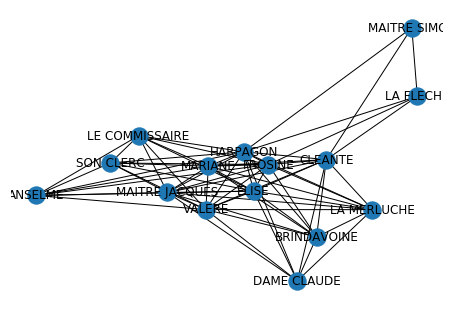

In [233]:
nx.draw(g, with_labels = True)